## Imports

In [ ]:
# EXPORT
# --- Must haves ---
import os, sys
sys.path.append('..')

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.cuda as cuda
import torch.nn as nn
import torchvision
import torch.nn.functional as F

from surrogates4sims.mantaflowDatasets import MantaFlowDataset, getSingleSim, createMantaFlowTrainTest

from surrogates4sims.utils import create_opt, create_one_cycle, find_lr, printNumModelParams, \
                                    rmse, writeMessage, plotSampleWprediction, plotSampleWpredictionByChannel, \
                                    plotSample, curl, jacobian, stream2uv, create_movie, convertSimToImage

from surrogates4sims.models import Generator, Encoder, AE_no_P, AE_xhat_z, AE_xhat_zV2

from surrogates4sims.train import trainEpoch, validEpoch

import numpy as np
from tqdm import tqdm
from copy import deepcopy

## Settings

In [ ]:
DEBUG = False
# model name, for tensorboard recording and checkpointing purposes.
versionName = "plateau_train"

# GPU Numbers to use. Comma seprate them for multi-GPUs.
gpu_ids = "2"
versionName = versionName + '_GPUs{}'.format(gpu_ids.replace(',',''))
# path to load model weights.
pretrained_path = None

# rate at which to record metrics. (number of batches to average over when recording metrics, e.g. "every 5 batches")
tensorboard_rate = 5

# number of epochs to train. This is defined here so we can use the OneCycle LR Scheduler.
epochs = 1000

# Data Directory
dataDirec = '/data/mantaFlowSim/data/smoke_pos21_size5_f200/v'
reverseXY = False 

# checkpoint directory
cps = 'cps'
tensorboard_direc = "tb"

findLRs = False  

# hyper-params
seed = 1234
np.random.seed(seed)
testSplit = .1
bz = 75
numSamplesToKeep = np.infty #if not debugging
latentDim = 16
filters = 128
num_conv = 4 # breaks when less than 2
simLen = 200
stack = True
simVizIndex = 0 # sim in the test set to visualize
createStreamFcn = False
doJacobian = False
repeat = 0
skip_connection = False
patience = 2
if DEBUG:
    epochs = 10000
    numSamplesToKeep = bz
    
versionName = versionName + '_latentDim{}_filters{}_bz{}_numConv{}_stream{}_jacobian{}_epochs{}_stack{}'.format(latentDim,filters,bz,num_conv,createStreamFcn,doJacobian,epochs,stack)
versionName

'plateau_train_GPUs2_latentDim512_filters128_bz75_numConv4_streamFalse_jacobianFalse_epochs1000_stackTrue'

### Select Personal GPUs

In [ ]:
!nvidia-smi

Fri Oct 23 13:29:30 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    Off  | 00000000:02:00.0 Off |                  N/A |
| 23%   24C    P8     8W / 250W |   3483MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN X (Pascal)    Off  | 00000000:03:00.0 Off |                  N/A |
| 23%   20C    P8     8W / 250W |   4000MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [ ]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_ids

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [ ]:
if device.type == 'cuda':
    print(cuda.is_available())
    print(cuda.device_count())
    print(cuda.current_device())
    print(cuda.get_device_name())

True
1
0
TITAN X (Pascal)


In [ ]:
a = torch.zeros(5, device=device.type)
!nvidia-smi

Fri Oct 23 13:29:34 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    Off  | 00000000:02:00.0 Off |                  N/A |
| 23%   24C    P8     9W / 250W |   3483MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN X (Pascal)    Off  | 00000000:03:00.0 Off |                  N/A |
| 23%   20C    P8     8W / 250W |   4000MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

## Datasets & Loaders

In [ ]:
trainData, testData = createMantaFlowTrainTest(dataDirec,simLen,testSplit,seed)
print((len(trainData),len(testData)))

(19000, 2000)


In [ ]:
# datasets may be smaller because: numSamplesToKeep 
testDataset = MantaFlowDataset(testData, reverseXY=reverseXY, numToKeep=numSamplesToKeep, AE=False)
trainDataset = MantaFlowDataset(trainData, reverseXY=reverseXY,numToKeep=numSamplesToKeep, AE=False)
len(trainDataset), len(testDataset)

100%|██████████| 19000/19000 [06:07<00:00, 51.67it/s]


(19000, 2000)

In [ ]:
trainDataLoader = DataLoader(dataset=trainDataset, batch_size=bz, shuffle=True, drop_last=True)
testDataLoader = DataLoader(dataset=testDataset, batch_size=bz)

## Model

Currently, the models need to take data to be built. It's kinda weird. I may look into fix this later. 

In [ ]:
X,p = next(iter(trainDataLoader))
X = X.to(device)
p = p.to(device)
X.shape, p.shape

(torch.Size([75, 2, 128, 96]), torch.Size([75, 3]))

In [ ]:
model = AE_xhat_zV2(X, filters, latentDim, num_conv, repeat, 
                 skip_connection, stack, conv_k=3, last_k=3, 
                 act=nn.LeakyReLU(), return_z=True, stream=createStreamFcn, device=device)

if len(gpu_ids.split(',')) > 1:
    model = nn.DataParallel(model)

In [ ]:
def printNumModelParams(model):
    layers_req_grad = 0
    tot_layers = 0

    params_req_grad = 0
    tot_params = 0

    for param in model.named_parameters():
        #print(param[0])
        if (param[1].requires_grad):
            layers_req_grad += 1
            params_req_grad += param[1].nelement()
        tot_layers += 1
        tot_params += param[1].nelement()
    print("{0:,} layers require gradients (unfrozen) out of {1:,} layers".format(layers_req_grad, tot_layers))
    print("{0:,} parameters require gradients (unfrozen) out of {1:,} parameters".format(params_req_grad, tot_params))
    

In [ ]:
printNumModelParams(model)

154 layers require gradients (unfrozen) out of 154 layers
16,303,362 parameters require gradients (unfrozen) out of 16,303,362 parameters


In [ ]:
Xhat,z = model(X)
Xhat.shape, z.shape

(torch.Size([75, 2, 128, 96]), torch.Size([75, 512]))

## Loss Function

In [ ]:
def L1_loss(pred, target):
    return torch.mean(torch.abs(pred - target))


def jacobian_loss(pred, target, device='cpu'):
    return L1_loss(jacobian(pred, device), jacobian(target, device))


def curl_loss(pred, target, device):
    return L1_loss(curl(pred, device), curl(target, device))


L = nn.MSELoss()


def p_loss(pred, target):
    return L(pred[:, -target.shape[1]:], target)


def loss(pred, target, device):
    
    if createStreamFcn:
        pred = stream2uv(pred, device)
        
    L1 = L1_loss(pred, target)
    Lj = 0
    if doJacobian:
        Lj = jacobian_loss(pred, target, device)
        
    return L1 + Lj

In [ ]:
pred = stream2uv(Xhat,device)
pred.shape

torch.Size([75, 2, 128, 96])

In [ ]:
loss(pred,X,device)

tensor(0.0952, device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
p_loss(z,p)

tensor(0.4174, device='cuda:0', grad_fn=<MseLossBackward>)

## Set LR

In [ ]:
if findLRs and (len(gpu_ids.split(','))==1): # doesn't work for multigpu???
    from copy import deepcopy
    model.return_z = False
    ae_dataset = deepcopy(trainDataset)
    ae_dataset.AE = True # only output (X,X), i.e. no p.
    dataLoader = DataLoader(ae_dataset,batch_size=bz)
    opt = create_opt(1e-7,model)
    find_lr(model,opt,L,device,dataLoader)
    model.return_z = True

In [ ]:
max_lr = .0001
start_lr = 5*max_lr/10
#opt = create_opt(max_lr,model)
#lr_scheduler = create_one_cycle(opt,max_lr,epochs,trainDataLoader)
opt = torch.optim.Adam(model.parameters(),lr=max_lr,betas=(.5,.999))
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,patience=patience)

In [ ]:
versionName = versionName + '_lr{}'.format(str(max_lr))

## Train

In [ ]:
def trainEpoch(myDataLoader, tensorboard_writer, model, opt, p_loss, loss,
               metric, lr_scheduler, tensorboard_rate, device,
               tensorboard_recorder_step, total_steps):
    running_loss = 0.0
    running_rmse = 0.0
    total_loss = 0.0
    running_ploss = 0.0
    for i, sampleBatch in enumerate(myDataLoader, start=1):

        # --- Main Training ---
        
        # gpu
        X,p = sampleBatch[0],sampleBatch[1]
        X = X.to(device)
        p = p.to(device)

        # zero the parameter gradients
        opt.zero_grad()

        X_hat, z = model(X)
        pl = p_loss(z,p)
        ll = loss(X_hat,X,device)
        combined_loss = pl + ll
        combined_loss.backward()
        opt.step()
        
        # loss
        batch_loss = combined_loss.item()
        running_loss += batch_loss
        total_loss += batch_loss
        
        batch_ploss = pl.item()
        running_ploss += batch_ploss

        # --- Metrics Recording ---

        # metrics
        r = metric(X_hat, X)
        running_rmse += r

        # record lr change
        total_steps += 1
        tensorboard_writer.add_scalar(tag="LR", scalar_value=opt.param_groups[0]['lr'], global_step=total_steps)
        #lr_scheduler.step()

        # tensorboard writes
        if (i % tensorboard_rate == 0):
            tensorboard_recorder_step += 1
            avg_running_loss = running_loss/tensorboard_rate
            avg_running_rmse = running_rmse/tensorboard_rate
            avg_running_ploss = running_ploss/tensorboard_rate
            tensorboard_writer.add_scalar(tag="Loss", scalar_value=avg_running_loss, global_step=tensorboard_recorder_step)
            tensorboard_writer.add_scalar(tag="p_loss", scalar_value=avg_running_ploss, global_step=tensorboard_recorder_step)
            tensorboard_writer.add_scalar(tag=metric.__name__, scalar_value=avg_running_rmse, global_step=tensorboard_recorder_step)
            # reset running_loss for the next set of batches. (tensorboard_rate number of batches)
            running_loss = 0.0
            running_rmse = 0.0
            running_ploss = 0.0

    return total_loss, tensorboard_recorder_step, total_steps

In [ ]:
try:
    os.mkdir(cps)
except:
    print("checkpoints directory already exists :)")

checkpoints directory already exists :)


In [ ]:
# create a summary writer.
train_writer = SummaryWriter(os.path.join(tensorboard_direc, versionName,'train'))
test_writer = SummaryWriter(os.path.join(tensorboard_direc, versionName,'valid'))
tensorboard_recorder_step = 0
total_steps = 0

In [ ]:
writeMessage('---------- Started Training ----------', versionName)
bestLoss = np.infty

for epoch in tqdm(range(1, epochs+1)):  # loop over the dataset multiple times
    
    writeMessage("--- Epoch {0}/{1} ---".format(epoch, epochs), versionName)
    
    model.train()
    trainLoss, tensorboard_recorder_step, total_steps = trainEpoch(trainDataLoader, 
                                                                   train_writer, model, opt, p_loss, loss,
                                                                   rmse, lr_scheduler, 
                                                                   tensorboard_rate, device,
                                                                   tensorboard_recorder_step, total_steps)
    
    writeMessage("trainLoss: {:.4e}".format(trainLoss),versionName)
    writeMessage("LR: {:.4e}".format(opt.param_groups[0]['lr']),versionName)
    if trainLoss < bestLoss:
        bestLoss = trainLoss
        writeMessage("Better trainLoss: {:.4e}, Saving models...".format(bestLoss),versionName)
        torch.save(model.state_dict(), os.path.join(cps,versionName))
        
#     model.eval()
#     valLoss = validEpoch(testDataLoader, test_writer, model, p_loss, loss, rmse, device, tensorboard_recorder_step)
#     writeMessage("valLoss: {:.4e}".format(valLoss),versionName)
    
    # checkpoint progress
#     if valLoss < bestLoss:
#         bestLoss = valLoss
#         writeMessage("Better valLoss: {:.4e}, Saving models...".format(bestLoss),versionName)
#         torch.save(model.state_dict(), os.path.join(cps,versionName))

    lr_scheduler.step(trainLoss)
    
    if opt.param_groups[0]['lr'] < 1e-8:
        break
writeMessage('---------- Finished Training ----------', versionName)

  0%|          | 0/1000 [00:00<?, ?it/s]

---------- Started Training ----------
--- Epoch 1/1000 ---
trainLoss: 2.0649e+01
LR: 1.0000e-04
Better trainLoss: 2.0649e+01, Saving models...


  0%|          | 1/1000 [01:13<20:31:54, 73.99s/it]

--- Epoch 2/1000 ---


  0%|          | 2/1000 [02:28<20:31:47, 74.06s/it]

trainLoss: 9.3643e+00
LR: 1.0000e-04
Better trainLoss: 9.3643e+00, Saving models...
--- Epoch 3/1000 ---


  0%|          | 3/1000 [03:42<20:32:18, 74.16s/it]

trainLoss: 7.2462e+00
LR: 1.0000e-04
Better trainLoss: 7.2462e+00, Saving models...
--- Epoch 4/1000 ---


  0%|          | 4/1000 [04:56<20:31:55, 74.21s/it]

trainLoss: 6.4188e+00
LR: 1.0000e-04
Better trainLoss: 6.4188e+00, Saving models...
--- Epoch 5/1000 ---


  0%|          | 5/1000 [06:11<20:32:12, 74.30s/it]

trainLoss: 5.4993e+00
LR: 1.0000e-04
Better trainLoss: 5.4993e+00, Saving models...
--- Epoch 6/1000 ---


  1%|          | 6/1000 [07:25<20:31:22, 74.33s/it]

trainLoss: 5.2424e+00
LR: 1.0000e-04
Better trainLoss: 5.2424e+00, Saving models...
--- Epoch 7/1000 ---


  1%|          | 7/1000 [08:40<20:31:28, 74.41s/it]

trainLoss: 4.8390e+00
LR: 1.0000e-04
Better trainLoss: 4.8390e+00, Saving models...
--- Epoch 8/1000 ---


  1%|          | 8/1000 [09:55<20:32:32, 74.55s/it]

trainLoss: 4.5540e+00
LR: 1.0000e-04
Better trainLoss: 4.5540e+00, Saving models...
--- Epoch 9/1000 ---


  1%|          | 9/1000 [11:09<20:31:35, 74.57s/it]

trainLoss: 4.1983e+00
LR: 1.0000e-04
Better trainLoss: 4.1983e+00, Saving models...
--- Epoch 10/1000 ---


  1%|          | 10/1000 [12:24<20:29:08, 74.49s/it]

trainLoss: 3.9600e+00
LR: 1.0000e-04
Better trainLoss: 3.9600e+00, Saving models...
--- Epoch 11/1000 ---


  1%|          | 11/1000 [13:38<20:28:26, 74.53s/it]

trainLoss: 3.8732e+00
LR: 1.0000e-04
Better trainLoss: 3.8732e+00, Saving models...
--- Epoch 12/1000 ---


  1%|          | 12/1000 [14:53<20:28:47, 74.62s/it]

trainLoss: 3.6877e+00
LR: 1.0000e-04
Better trainLoss: 3.6877e+00, Saving models...
--- Epoch 13/1000 ---


  1%|▏         | 13/1000 [16:08<20:27:26, 74.62s/it]

trainLoss: 3.6069e+00
LR: 1.0000e-04
Better trainLoss: 3.6069e+00, Saving models...
--- Epoch 14/1000 ---


  1%|▏         | 14/1000 [17:22<20:25:55, 74.60s/it]

trainLoss: 3.5219e+00
LR: 1.0000e-04
Better trainLoss: 3.5219e+00, Saving models...
--- Epoch 15/1000 ---


  2%|▏         | 15/1000 [18:37<20:25:08, 74.63s/it]

trainLoss: 3.4661e+00
LR: 1.0000e-04
Better trainLoss: 3.4661e+00, Saving models...
--- Epoch 16/1000 ---


  2%|▏         | 16/1000 [19:52<20:23:27, 74.60s/it]

trainLoss: 6.5421e+00
LR: 1.0000e-04
--- Epoch 17/1000 ---


  2%|▏         | 17/1000 [21:06<20:23:07, 74.66s/it]

trainLoss: 4.1406e+00
LR: 1.0000e-04
--- Epoch 18/1000 ---


  2%|▏         | 18/1000 [22:21<20:21:32, 74.64s/it]

trainLoss: 4.0275e+00
LR: 1.0000e-04
--- Epoch 19/1000 ---


  2%|▏         | 19/1000 [23:35<20:19:21, 74.58s/it]

trainLoss: 2.5227e+00
LR: 1.0000e-05
Better trainLoss: 2.5227e+00, Saving models...
--- Epoch 20/1000 ---


  2%|▏         | 20/1000 [24:50<20:18:39, 74.61s/it]

trainLoss: 2.3938e+00
LR: 1.0000e-05
Better trainLoss: 2.3938e+00, Saving models...
--- Epoch 21/1000 ---


  2%|▏         | 21/1000 [26:05<20:19:25, 74.73s/it]

trainLoss: 2.3376e+00
LR: 1.0000e-05
Better trainLoss: 2.3376e+00, Saving models...
--- Epoch 22/1000 ---


  2%|▏         | 22/1000 [27:20<20:18:11, 74.74s/it]

trainLoss: 2.3047e+00
LR: 1.0000e-05
Better trainLoss: 2.3047e+00, Saving models...
--- Epoch 23/1000 ---


  2%|▏         | 23/1000 [28:34<20:15:46, 74.66s/it]

trainLoss: 2.2700e+00
LR: 1.0000e-05
Better trainLoss: 2.2700e+00, Saving models...
--- Epoch 24/1000 ---


  2%|▏         | 24/1000 [29:49<20:15:50, 74.74s/it]

trainLoss: 2.2431e+00
LR: 1.0000e-05
Better trainLoss: 2.2431e+00, Saving models...
--- Epoch 25/1000 ---


  2%|▎         | 25/1000 [31:04<20:14:35, 74.74s/it]

trainLoss: 2.2205e+00
LR: 1.0000e-05
Better trainLoss: 2.2205e+00, Saving models...
--- Epoch 26/1000 ---


  3%|▎         | 26/1000 [32:19<20:13:49, 74.77s/it]

trainLoss: 2.1963e+00
LR: 1.0000e-05
Better trainLoss: 2.1963e+00, Saving models...
--- Epoch 27/1000 ---


  3%|▎         | 27/1000 [33:34<20:12:21, 74.76s/it]

trainLoss: 2.1721e+00
LR: 1.0000e-05
Better trainLoss: 2.1721e+00, Saving models...
--- Epoch 28/1000 ---


  3%|▎         | 28/1000 [34:48<20:10:13, 74.71s/it]

trainLoss: 2.1536e+00
LR: 1.0000e-05
Better trainLoss: 2.1536e+00, Saving models...
--- Epoch 29/1000 ---


  3%|▎         | 29/1000 [36:03<20:08:02, 74.65s/it]

trainLoss: 2.1350e+00
LR: 1.0000e-05
Better trainLoss: 2.1350e+00, Saving models...
--- Epoch 30/1000 ---


  3%|▎         | 30/1000 [37:18<20:08:56, 74.78s/it]

trainLoss: 2.1120e+00
LR: 1.0000e-05
Better trainLoss: 2.1120e+00, Saving models...
--- Epoch 31/1000 ---


  3%|▎         | 31/1000 [38:33<20:07:33, 74.77s/it]

trainLoss: 2.0952e+00
LR: 1.0000e-05
Better trainLoss: 2.0952e+00, Saving models...
--- Epoch 32/1000 ---


  3%|▎         | 32/1000 [39:47<20:06:33, 74.79s/it]

trainLoss: 2.0819e+00
LR: 1.0000e-05
Better trainLoss: 2.0819e+00, Saving models...
--- Epoch 33/1000 ---


  3%|▎         | 33/1000 [41:02<20:04:45, 74.75s/it]

trainLoss: 2.0677e+00
LR: 1.0000e-05
Better trainLoss: 2.0677e+00, Saving models...
--- Epoch 34/1000 ---


  3%|▎         | 34/1000 [42:17<20:03:33, 74.75s/it]

trainLoss: 2.0520e+00
LR: 1.0000e-05
Better trainLoss: 2.0520e+00, Saving models...
--- Epoch 35/1000 ---


  4%|▎         | 35/1000 [43:32<20:02:14, 74.75s/it]

trainLoss: 2.0369e+00
LR: 1.0000e-05
Better trainLoss: 2.0369e+00, Saving models...
--- Epoch 36/1000 ---


  4%|▎         | 36/1000 [44:46<19:59:48, 74.68s/it]

trainLoss: 2.0308e+00
LR: 1.0000e-05
Better trainLoss: 2.0308e+00, Saving models...
--- Epoch 37/1000 ---


  4%|▎         | 37/1000 [46:01<19:59:17, 74.72s/it]

trainLoss: 2.0041e+00
LR: 1.0000e-05
Better trainLoss: 2.0041e+00, Saving models...
--- Epoch 38/1000 ---


  4%|▍         | 38/1000 [47:15<19:57:28, 74.69s/it]

trainLoss: 1.9875e+00
LR: 1.0000e-05
Better trainLoss: 1.9875e+00, Saving models...
--- Epoch 39/1000 ---


  4%|▍         | 39/1000 [48:30<19:56:56, 74.73s/it]

trainLoss: 1.9758e+00
LR: 1.0000e-05
Better trainLoss: 1.9758e+00, Saving models...
--- Epoch 40/1000 ---


  4%|▍         | 40/1000 [49:45<19:54:25, 74.65s/it]

trainLoss: 1.9776e+00
LR: 1.0000e-05
--- Epoch 41/1000 ---


  4%|▍         | 41/1000 [51:00<19:53:51, 74.69s/it]

trainLoss: 1.9537e+00
LR: 1.0000e-05
Better trainLoss: 1.9537e+00, Saving models...
--- Epoch 42/1000 ---


  4%|▍         | 42/1000 [52:14<19:52:57, 74.72s/it]

trainLoss: 1.9477e+00
LR: 1.0000e-05
Better trainLoss: 1.9477e+00, Saving models...
--- Epoch 43/1000 ---


  4%|▍         | 43/1000 [53:29<19:53:08, 74.80s/it]

trainLoss: 1.9384e+00
LR: 1.0000e-05
Better trainLoss: 1.9384e+00, Saving models...
--- Epoch 44/1000 ---


  4%|▍         | 44/1000 [54:44<19:52:00, 74.81s/it]

trainLoss: 1.9296e+00
LR: 1.0000e-05
Better trainLoss: 1.9296e+00, Saving models...
--- Epoch 45/1000 ---


  4%|▍         | 45/1000 [55:59<19:52:00, 74.89s/it]

trainLoss: 1.9077e+00
LR: 1.0000e-05
Better trainLoss: 1.9077e+00, Saving models...
--- Epoch 46/1000 ---


  5%|▍         | 46/1000 [57:14<19:49:57, 74.84s/it]

trainLoss: 1.9031e+00
LR: 1.0000e-05
Better trainLoss: 1.9031e+00, Saving models...
--- Epoch 47/1000 ---


  5%|▍         | 47/1000 [58:28<19:46:58, 74.73s/it]

trainLoss: 1.8905e+00
LR: 1.0000e-05
Better trainLoss: 1.8905e+00, Saving models...
--- Epoch 48/1000 ---


  5%|▍         | 48/1000 [59:43<19:45:09, 74.69s/it]

trainLoss: 1.8825e+00
LR: 1.0000e-05
Better trainLoss: 1.8825e+00, Saving models...
--- Epoch 49/1000 ---


  5%|▍         | 49/1000 [1:00:58<19:43:21, 74.66s/it]

trainLoss: 1.8644e+00
LR: 1.0000e-05
Better trainLoss: 1.8644e+00, Saving models...
--- Epoch 50/1000 ---


  5%|▌         | 50/1000 [1:02:12<19:42:41, 74.70s/it]

trainLoss: 1.8571e+00
LR: 1.0000e-05
Better trainLoss: 1.8571e+00, Saving models...
--- Epoch 51/1000 ---


  5%|▌         | 51/1000 [1:03:27<19:40:53, 74.66s/it]

trainLoss: 1.8514e+00
LR: 1.0000e-05
Better trainLoss: 1.8514e+00, Saving models...
--- Epoch 52/1000 ---


  5%|▌         | 52/1000 [1:04:42<19:39:42, 74.67s/it]

trainLoss: 1.8429e+00
LR: 1.0000e-05
Better trainLoss: 1.8429e+00, Saving models...
--- Epoch 53/1000 ---


  5%|▌         | 53/1000 [1:05:57<19:39:31, 74.73s/it]

trainLoss: 1.8291e+00
LR: 1.0000e-05
Better trainLoss: 1.8291e+00, Saving models...
--- Epoch 54/1000 ---


  5%|▌         | 54/1000 [1:07:11<19:37:47, 74.70s/it]

trainLoss: 1.8232e+00
LR: 1.0000e-05
Better trainLoss: 1.8232e+00, Saving models...
--- Epoch 55/1000 ---


  6%|▌         | 55/1000 [1:08:26<19:36:55, 74.73s/it]

trainLoss: 1.8124e+00
LR: 1.0000e-05
Better trainLoss: 1.8124e+00, Saving models...
--- Epoch 56/1000 ---


  6%|▌         | 56/1000 [1:09:41<19:35:36, 74.72s/it]

trainLoss: 1.8074e+00
LR: 1.0000e-05
Better trainLoss: 1.8074e+00, Saving models...
--- Epoch 57/1000 ---


  6%|▌         | 57/1000 [1:10:56<19:36:10, 74.84s/it]

trainLoss: 1.7961e+00
LR: 1.0000e-05
Better trainLoss: 1.7961e+00, Saving models...
--- Epoch 58/1000 ---


  6%|▌         | 58/1000 [1:12:10<19:33:02, 74.72s/it]

trainLoss: 1.7851e+00
LR: 1.0000e-05
Better trainLoss: 1.7851e+00, Saving models...
--- Epoch 59/1000 ---


  6%|▌         | 59/1000 [1:13:25<19:32:27, 74.76s/it]

trainLoss: 1.7796e+00
LR: 1.0000e-05
Better trainLoss: 1.7796e+00, Saving models...
--- Epoch 60/1000 ---


  6%|▌         | 60/1000 [1:14:40<19:30:31, 74.71s/it]

trainLoss: 1.7700e+00
LR: 1.0000e-05
Better trainLoss: 1.7700e+00, Saving models...
--- Epoch 61/1000 ---


  6%|▌         | 61/1000 [1:15:54<19:29:02, 74.70s/it]

trainLoss: 1.7651e+00
LR: 1.0000e-05
Better trainLoss: 1.7651e+00, Saving models...
--- Epoch 62/1000 ---


  6%|▌         | 62/1000 [1:17:09<19:26:23, 74.61s/it]

trainLoss: 1.7627e+00
LR: 1.0000e-05
Better trainLoss: 1.7627e+00, Saving models...
--- Epoch 63/1000 ---


  6%|▋         | 63/1000 [1:18:24<19:26:13, 74.68s/it]

trainLoss: 1.7472e+00
LR: 1.0000e-05
Better trainLoss: 1.7472e+00, Saving models...
--- Epoch 64/1000 ---


  6%|▋         | 64/1000 [1:19:39<19:26:28, 74.77s/it]

trainLoss: 1.7426e+00
LR: 1.0000e-05
Better trainLoss: 1.7426e+00, Saving models...
--- Epoch 65/1000 ---


  6%|▋         | 65/1000 [1:20:53<19:23:12, 74.64s/it]

trainLoss: 1.7390e+00
LR: 1.0000e-05
Better trainLoss: 1.7390e+00, Saving models...
--- Epoch 66/1000 ---


  7%|▋         | 66/1000 [1:22:08<19:22:39, 74.69s/it]

trainLoss: 1.7232e+00
LR: 1.0000e-05
Better trainLoss: 1.7232e+00, Saving models...
--- Epoch 67/1000 ---


  7%|▋         | 67/1000 [1:23:22<19:21:17, 74.68s/it]

trainLoss: 1.7133e+00
LR: 1.0000e-05
Better trainLoss: 1.7133e+00, Saving models...
--- Epoch 68/1000 ---


  7%|▋         | 68/1000 [1:24:37<19:21:23, 74.77s/it]

trainLoss: 1.7084e+00
LR: 1.0000e-05
Better trainLoss: 1.7084e+00, Saving models...
--- Epoch 69/1000 ---


  7%|▋         | 69/1000 [1:25:52<19:20:17, 74.78s/it]

trainLoss: 1.7045e+00
LR: 1.0000e-05
Better trainLoss: 1.7045e+00, Saving models...
--- Epoch 70/1000 ---
trainLoss: 1.6950e+00
LR: 1.0000e-05
Better trainLoss: 1.6950e+00, Saving models...


  7%|▋         | 70/1000 [1:27:07<19:19:22, 74.80s/it]

--- Epoch 71/1000 ---
trainLoss: 1.6911e+00
LR: 1.0000e-05
Better trainLoss: 1.6911e+00, Saving models...


  7%|▋         | 71/1000 [1:28:22<19:18:05, 74.80s/it]

--- Epoch 72/1000 ---


  7%|▋         | 72/1000 [1:29:37<19:16:48, 74.79s/it]

trainLoss: 1.6828e+00
LR: 1.0000e-05
Better trainLoss: 1.6828e+00, Saving models...
--- Epoch 73/1000 ---


  7%|▋         | 73/1000 [1:30:52<19:16:15, 74.84s/it]

trainLoss: 1.6801e+00
LR: 1.0000e-05
Better trainLoss: 1.6801e+00, Saving models...
--- Epoch 74/1000 ---


  7%|▋         | 74/1000 [1:32:06<19:14:41, 74.82s/it]

trainLoss: 1.6736e+00
LR: 1.0000e-05
Better trainLoss: 1.6736e+00, Saving models...
--- Epoch 75/1000 ---


  8%|▊         | 75/1000 [1:33:21<19:12:37, 74.76s/it]

trainLoss: 1.6641e+00
LR: 1.0000e-05
Better trainLoss: 1.6641e+00, Saving models...
--- Epoch 76/1000 ---


  8%|▊         | 76/1000 [1:34:36<19:11:12, 74.75s/it]

trainLoss: 1.6559e+00
LR: 1.0000e-05
Better trainLoss: 1.6559e+00, Saving models...
--- Epoch 77/1000 ---


  8%|▊         | 77/1000 [1:35:50<19:08:41, 74.67s/it]

trainLoss: 1.6565e+00
LR: 1.0000e-05
--- Epoch 78/1000 ---


  8%|▊         | 78/1000 [1:37:05<19:06:38, 74.62s/it]

trainLoss: 1.6457e+00
LR: 1.0000e-05
Better trainLoss: 1.6457e+00, Saving models...
--- Epoch 79/1000 ---


  8%|▊         | 79/1000 [1:38:19<19:06:00, 74.66s/it]

trainLoss: 1.6397e+00
LR: 1.0000e-05
Better trainLoss: 1.6397e+00, Saving models...
--- Epoch 80/1000 ---


  8%|▊         | 80/1000 [1:39:34<19:05:41, 74.72s/it]

trainLoss: 1.6366e+00
LR: 1.0000e-05
Better trainLoss: 1.6366e+00, Saving models...
--- Epoch 81/1000 ---


  8%|▊         | 81/1000 [1:40:49<19:05:10, 74.77s/it]

trainLoss: 1.6288e+00
LR: 1.0000e-05
Better trainLoss: 1.6288e+00, Saving models...
--- Epoch 82/1000 ---


  8%|▊         | 82/1000 [1:42:04<19:03:52, 74.76s/it]

trainLoss: 1.6271e+00
LR: 1.0000e-05
Better trainLoss: 1.6271e+00, Saving models...
--- Epoch 83/1000 ---


  8%|▊         | 83/1000 [1:43:19<19:04:03, 74.86s/it]

trainLoss: 1.6259e+00
LR: 1.0000e-05
Better trainLoss: 1.6259e+00, Saving models...
--- Epoch 84/1000 ---


  8%|▊         | 84/1000 [1:44:34<19:01:31, 74.77s/it]

trainLoss: 1.6120e+00
LR: 1.0000e-05
Better trainLoss: 1.6120e+00, Saving models...
--- Epoch 85/1000 ---


  8%|▊         | 85/1000 [1:45:48<18:58:56, 74.68s/it]

trainLoss: 1.6123e+00
LR: 1.0000e-05
--- Epoch 86/1000 ---


  9%|▊         | 86/1000 [1:47:03<18:58:11, 74.72s/it]

trainLoss: 1.5972e+00
LR: 1.0000e-05
Better trainLoss: 1.5972e+00, Saving models...
--- Epoch 87/1000 ---


  9%|▊         | 87/1000 [1:48:18<18:57:23, 74.75s/it]

trainLoss: 1.5953e+00
LR: 1.0000e-05
Better trainLoss: 1.5953e+00, Saving models...
--- Epoch 88/1000 ---


  9%|▉         | 88/1000 [1:49:33<18:56:53, 74.80s/it]

trainLoss: 1.5971e+00
LR: 1.0000e-05
--- Epoch 89/1000 ---


  9%|▉         | 89/1000 [1:50:47<18:54:41, 74.73s/it]

trainLoss: 1.5828e+00
LR: 1.0000e-05
Better trainLoss: 1.5828e+00, Saving models...
--- Epoch 90/1000 ---


  9%|▉         | 90/1000 [1:52:02<18:53:46, 74.75s/it]

trainLoss: 1.5847e+00
LR: 1.0000e-05
--- Epoch 91/1000 ---


  9%|▉         | 91/1000 [1:53:17<18:52:08, 74.73s/it]

trainLoss: 1.5821e+00
LR: 1.0000e-05
Better trainLoss: 1.5821e+00, Saving models...
--- Epoch 92/1000 ---


  9%|▉         | 92/1000 [1:54:31<18:51:15, 74.75s/it]

trainLoss: 1.5720e+00
LR: 1.0000e-05
Better trainLoss: 1.5720e+00, Saving models...
--- Epoch 93/1000 ---


  9%|▉         | 93/1000 [1:55:46<18:50:41, 74.80s/it]

trainLoss: 1.5726e+00
LR: 1.0000e-05
--- Epoch 94/1000 ---


  9%|▉         | 94/1000 [1:57:01<18:49:38, 74.81s/it]

trainLoss: 1.5634e+00
LR: 1.0000e-05
Better trainLoss: 1.5634e+00, Saving models...
--- Epoch 95/1000 ---


 10%|▉         | 95/1000 [1:58:16<18:47:50, 74.77s/it]

trainLoss: 1.5594e+00
LR: 1.0000e-05
Better trainLoss: 1.5594e+00, Saving models...
--- Epoch 96/1000 ---


 10%|▉         | 96/1000 [1:59:31<18:47:00, 74.80s/it]

trainLoss: 1.5519e+00
LR: 1.0000e-05
Better trainLoss: 1.5519e+00, Saving models...
--- Epoch 97/1000 ---


 10%|▉         | 97/1000 [2:00:45<18:45:46, 74.80s/it]

trainLoss: 1.5477e+00
LR: 1.0000e-05
Better trainLoss: 1.5477e+00, Saving models...
--- Epoch 98/1000 ---


 10%|▉         | 98/1000 [2:02:00<18:43:02, 74.70s/it]

trainLoss: 1.5450e+00
LR: 1.0000e-05
Better trainLoss: 1.5450e+00, Saving models...
--- Epoch 99/1000 ---


 10%|▉         | 99/1000 [2:03:15<18:41:23, 74.68s/it]

trainLoss: 1.5451e+00
LR: 1.0000e-05
--- Epoch 100/1000 ---


 10%|█         | 100/1000 [2:04:29<18:39:48, 74.65s/it]

trainLoss: 1.5400e+00
LR: 1.0000e-05
Better trainLoss: 1.5400e+00, Saving models...
--- Epoch 101/1000 ---


 10%|█         | 101/1000 [2:05:44<18:38:12, 74.63s/it]

trainLoss: 1.5317e+00
LR: 1.0000e-05
Better trainLoss: 1.5317e+00, Saving models...
--- Epoch 102/1000 ---


 10%|█         | 102/1000 [2:06:58<18:35:06, 74.51s/it]

trainLoss: 1.5258e+00
LR: 1.0000e-05
Better trainLoss: 1.5258e+00, Saving models...
--- Epoch 103/1000 ---


 10%|█         | 103/1000 [2:08:13<18:35:04, 74.59s/it]

trainLoss: 1.5252e+00
LR: 1.0000e-05
Better trainLoss: 1.5252e+00, Saving models...
--- Epoch 104/1000 ---


 10%|█         | 104/1000 [2:09:28<18:34:57, 74.66s/it]

trainLoss: 1.5203e+00
LR: 1.0000e-05
Better trainLoss: 1.5203e+00, Saving models...
--- Epoch 105/1000 ---


 10%|█         | 105/1000 [2:10:42<18:34:07, 74.69s/it]

trainLoss: 1.5195e+00
LR: 1.0000e-05
Better trainLoss: 1.5195e+00, Saving models...
--- Epoch 106/1000 ---


 11%|█         | 106/1000 [2:11:57<18:31:21, 74.59s/it]

trainLoss: 1.5185e+00
LR: 1.0000e-05
Better trainLoss: 1.5185e+00, Saving models...
--- Epoch 107/1000 ---


 11%|█         | 107/1000 [2:13:11<18:29:49, 74.57s/it]

trainLoss: 1.5150e+00
LR: 1.0000e-05
Better trainLoss: 1.5150e+00, Saving models...
--- Epoch 108/1000 ---


 11%|█         | 108/1000 [2:14:25<18:27:03, 74.47s/it]

trainLoss: 1.5156e+00
LR: 1.0000e-05
--- Epoch 109/1000 ---


 11%|█         | 109/1000 [2:15:40<18:25:54, 74.47s/it]

trainLoss: 1.5025e+00
LR: 1.0000e-05
Better trainLoss: 1.5025e+00, Saving models...
--- Epoch 110/1000 ---


 11%|█         | 110/1000 [2:16:54<18:24:48, 74.48s/it]

trainLoss: 1.5000e+00
LR: 1.0000e-05
Better trainLoss: 1.5000e+00, Saving models...
--- Epoch 111/1000 ---


 11%|█         | 111/1000 [2:18:09<18:23:23, 74.47s/it]

trainLoss: 1.4972e+00
LR: 1.0000e-05
Better trainLoss: 1.4972e+00, Saving models...
--- Epoch 112/1000 ---


 11%|█         | 112/1000 [2:19:23<18:22:40, 74.51s/it]

trainLoss: 1.4898e+00
LR: 1.0000e-05
Better trainLoss: 1.4898e+00, Saving models...
--- Epoch 113/1000 ---


 11%|█▏        | 113/1000 [2:20:38<18:20:46, 74.46s/it]

trainLoss: 1.4882e+00
LR: 1.0000e-05
Better trainLoss: 1.4882e+00, Saving models...
--- Epoch 114/1000 ---


 11%|█▏        | 114/1000 [2:21:52<18:19:54, 74.49s/it]

trainLoss: 1.4863e+00
LR: 1.0000e-05
Better trainLoss: 1.4863e+00, Saving models...
--- Epoch 115/1000 ---


 12%|█▏        | 115/1000 [2:23:07<18:17:30, 74.41s/it]

trainLoss: 1.4808e+00
LR: 1.0000e-05
Better trainLoss: 1.4808e+00, Saving models...
--- Epoch 116/1000 ---


 12%|█▏        | 116/1000 [2:24:21<18:15:35, 74.36s/it]

trainLoss: 1.4773e+00
LR: 1.0000e-05
Better trainLoss: 1.4773e+00, Saving models...
--- Epoch 117/1000 ---


 12%|█▏        | 117/1000 [2:25:35<18:13:37, 74.31s/it]

trainLoss: 1.4796e+00
LR: 1.0000e-05
--- Epoch 118/1000 ---


 12%|█▏        | 118/1000 [2:26:49<18:11:30, 74.25s/it]

trainLoss: 1.4767e+00
LR: 1.0000e-05
Better trainLoss: 1.4767e+00, Saving models...
--- Epoch 119/1000 ---


 12%|█▏        | 119/1000 [2:28:04<18:11:03, 74.31s/it]

trainLoss: 1.4670e+00
LR: 1.0000e-05
Better trainLoss: 1.4670e+00, Saving models...
--- Epoch 120/1000 ---


 12%|█▏        | 120/1000 [2:29:18<18:09:24, 74.28s/it]

trainLoss: 1.4619e+00
LR: 1.0000e-05
Better trainLoss: 1.4619e+00, Saving models...
--- Epoch 121/1000 ---


 12%|█▏        | 121/1000 [2:30:32<18:08:51, 74.32s/it]

trainLoss: 1.4604e+00
LR: 1.0000e-05
Better trainLoss: 1.4604e+00, Saving models...
--- Epoch 122/1000 ---


 12%|█▏        | 122/1000 [2:31:47<18:07:47, 74.34s/it]

trainLoss: 1.4565e+00
LR: 1.0000e-05
Better trainLoss: 1.4565e+00, Saving models...
--- Epoch 123/1000 ---


 12%|█▏        | 123/1000 [2:33:01<18:06:25, 74.33s/it]

trainLoss: 1.4596e+00
LR: 1.0000e-05
--- Epoch 124/1000 ---


 12%|█▏        | 124/1000 [2:34:15<18:04:59, 74.31s/it]

trainLoss: 1.4519e+00
LR: 1.0000e-05
Better trainLoss: 1.4519e+00, Saving models...
--- Epoch 125/1000 ---


 12%|█▎        | 125/1000 [2:35:29<18:03:02, 74.27s/it]

trainLoss: 1.4494e+00
LR: 1.0000e-05
Better trainLoss: 1.4494e+00, Saving models...
--- Epoch 126/1000 ---


 13%|█▎        | 126/1000 [2:36:44<18:02:16, 74.30s/it]

trainLoss: 1.4472e+00
LR: 1.0000e-05
Better trainLoss: 1.4472e+00, Saving models...
--- Epoch 127/1000 ---


 13%|█▎        | 127/1000 [2:37:58<18:01:50, 74.35s/it]

trainLoss: 1.4461e+00
LR: 1.0000e-05
Better trainLoss: 1.4461e+00, Saving models...
--- Epoch 128/1000 ---


 13%|█▎        | 128/1000 [2:39:12<18:00:15, 74.33s/it]

trainLoss: 1.4416e+00
LR: 1.0000e-05
Better trainLoss: 1.4416e+00, Saving models...
--- Epoch 129/1000 ---


 13%|█▎        | 129/1000 [2:40:27<17:57:59, 74.26s/it]

trainLoss: 1.4366e+00
LR: 1.0000e-05
Better trainLoss: 1.4366e+00, Saving models...
--- Epoch 130/1000 ---


 13%|█▎        | 130/1000 [2:41:41<17:56:16, 74.23s/it]

trainLoss: 1.4348e+00
LR: 1.0000e-05
Better trainLoss: 1.4348e+00, Saving models...
--- Epoch 131/1000 ---


 13%|█▎        | 131/1000 [2:42:55<17:54:53, 74.22s/it]

trainLoss: 1.4385e+00
LR: 1.0000e-05
--- Epoch 132/1000 ---


 13%|█▎        | 132/1000 [2:44:09<17:54:33, 74.28s/it]

trainLoss: 1.4280e+00
LR: 1.0000e-05
Better trainLoss: 1.4280e+00, Saving models...
--- Epoch 133/1000 ---


 13%|█▎        | 133/1000 [2:45:24<17:54:49, 74.38s/it]

trainLoss: 1.4266e+00
LR: 1.0000e-05
Better trainLoss: 1.4266e+00, Saving models...
--- Epoch 134/1000 ---


 13%|█▎        | 134/1000 [2:46:38<17:53:37, 74.39s/it]

trainLoss: 1.4281e+00
LR: 1.0000e-05
--- Epoch 135/1000 ---


 14%|█▎        | 135/1000 [2:47:53<17:52:22, 74.38s/it]

trainLoss: 1.4181e+00
LR: 1.0000e-05
Better trainLoss: 1.4181e+00, Saving models...
--- Epoch 136/1000 ---


 14%|█▎        | 136/1000 [2:49:07<17:52:13, 74.46s/it]

trainLoss: 1.4209e+00
LR: 1.0000e-05
--- Epoch 137/1000 ---


 14%|█▎        | 137/1000 [2:50:22<17:50:19, 74.41s/it]

trainLoss: 1.4153e+00
LR: 1.0000e-05
Better trainLoss: 1.4153e+00, Saving models...
--- Epoch 138/1000 ---


 14%|█▍        | 138/1000 [2:51:36<17:49:11, 74.42s/it]

trainLoss: 1.4108e+00
LR: 1.0000e-05
Better trainLoss: 1.4108e+00, Saving models...
--- Epoch 139/1000 ---


 14%|█▍        | 139/1000 [2:52:51<17:47:57, 74.42s/it]

trainLoss: 1.4130e+00
LR: 1.0000e-05
--- Epoch 140/1000 ---


 14%|█▍        | 140/1000 [2:54:05<17:48:06, 74.52s/it]

trainLoss: 1.4081e+00
LR: 1.0000e-05
Better trainLoss: 1.4081e+00, Saving models...
--- Epoch 141/1000 ---


 14%|█▍        | 141/1000 [2:55:20<17:46:09, 74.47s/it]

trainLoss: 1.4033e+00
LR: 1.0000e-05
Better trainLoss: 1.4033e+00, Saving models...
--- Epoch 142/1000 ---


 14%|█▍        | 142/1000 [2:56:34<17:44:30, 74.44s/it]

trainLoss: 1.4019e+00
LR: 1.0000e-05
Better trainLoss: 1.4019e+00, Saving models...
--- Epoch 143/1000 ---


 14%|█▍        | 143/1000 [2:57:48<17:41:26, 74.31s/it]

trainLoss: 1.4032e+00
LR: 1.0000e-05
--- Epoch 144/1000 ---


 14%|█▍        | 144/1000 [2:59:02<17:40:12, 74.31s/it]

trainLoss: 1.3998e+00
LR: 1.0000e-05
Better trainLoss: 1.3998e+00, Saving models...
--- Epoch 145/1000 ---


 14%|█▍        | 145/1000 [3:00:17<17:38:51, 74.31s/it]

trainLoss: 1.3976e+00
LR: 1.0000e-05
Better trainLoss: 1.3976e+00, Saving models...
--- Epoch 146/1000 ---


 15%|█▍        | 146/1000 [3:01:31<17:36:57, 74.26s/it]

trainLoss: 1.3996e+00
LR: 1.0000e-05
--- Epoch 147/1000 ---


 15%|█▍        | 147/1000 [3:02:45<17:37:43, 74.40s/it]

trainLoss: 1.3900e+00
LR: 1.0000e-05
Better trainLoss: 1.3900e+00, Saving models...
--- Epoch 148/1000 ---


 15%|█▍        | 148/1000 [3:04:00<17:36:50, 74.42s/it]

trainLoss: 1.3877e+00
LR: 1.0000e-05
Better trainLoss: 1.3877e+00, Saving models...
--- Epoch 149/1000 ---


 15%|█▍        | 149/1000 [3:05:14<17:34:53, 74.38s/it]

trainLoss: 1.3826e+00
LR: 1.0000e-05
Better trainLoss: 1.3826e+00, Saving models...
--- Epoch 150/1000 ---


 15%|█▌        | 150/1000 [3:06:28<17:32:02, 74.26s/it]

trainLoss: 1.3875e+00
LR: 1.0000e-05
--- Epoch 151/1000 ---


 15%|█▌        | 151/1000 [3:07:42<17:30:31, 74.24s/it]

trainLoss: 1.3814e+00
LR: 1.0000e-05
Better trainLoss: 1.3814e+00, Saving models...
--- Epoch 152/1000 ---


 15%|█▌        | 152/1000 [3:08:57<17:28:51, 74.21s/it]

trainLoss: 1.3812e+00
LR: 1.0000e-05
Better trainLoss: 1.3812e+00, Saving models...
--- Epoch 153/1000 ---


 15%|█▌        | 153/1000 [3:10:11<17:28:10, 74.25s/it]

trainLoss: 1.3794e+00
LR: 1.0000e-05
Better trainLoss: 1.3794e+00, Saving models...
--- Epoch 154/1000 ---


 15%|█▌        | 154/1000 [3:11:25<17:28:19, 74.35s/it]

trainLoss: 1.3735e+00
LR: 1.0000e-05
Better trainLoss: 1.3735e+00, Saving models...
--- Epoch 155/1000 ---


 16%|█▌        | 155/1000 [3:12:40<17:26:56, 74.34s/it]

trainLoss: 1.3743e+00
LR: 1.0000e-05
--- Epoch 156/1000 ---


 16%|█▌        | 156/1000 [3:13:54<17:25:00, 74.29s/it]

trainLoss: 1.3713e+00
LR: 1.0000e-05
Better trainLoss: 1.3713e+00, Saving models...
--- Epoch 157/1000 ---


 16%|█▌        | 157/1000 [3:15:08<17:24:04, 74.31s/it]

trainLoss: 1.3701e+00
LR: 1.0000e-05
Better trainLoss: 1.3701e+00, Saving models...
--- Epoch 158/1000 ---


 16%|█▌        | 158/1000 [3:16:23<17:23:23, 74.35s/it]

trainLoss: 1.3658e+00
LR: 1.0000e-05
Better trainLoss: 1.3658e+00, Saving models...
--- Epoch 159/1000 ---


 16%|█▌        | 159/1000 [3:17:37<17:21:09, 74.28s/it]

trainLoss: 1.3613e+00
LR: 1.0000e-05
Better trainLoss: 1.3613e+00, Saving models...
--- Epoch 160/1000 ---


 16%|█▌        | 160/1000 [3:18:51<17:19:48, 74.27s/it]

trainLoss: 1.3609e+00
LR: 1.0000e-05
Better trainLoss: 1.3609e+00, Saving models...
--- Epoch 161/1000 ---


 16%|█▌        | 161/1000 [3:20:06<17:18:55, 74.30s/it]

trainLoss: 1.3565e+00
LR: 1.0000e-05
Better trainLoss: 1.3565e+00, Saving models...
--- Epoch 162/1000 ---


 16%|█▌        | 162/1000 [3:21:20<17:18:33, 74.36s/it]

trainLoss: 1.3562e+00
LR: 1.0000e-05
Better trainLoss: 1.3562e+00, Saving models...
--- Epoch 163/1000 ---


 16%|█▋        | 163/1000 [3:22:34<17:16:45, 74.32s/it]

trainLoss: 1.3548e+00
LR: 1.0000e-05
Better trainLoss: 1.3548e+00, Saving models...
--- Epoch 164/1000 ---


 16%|█▋        | 164/1000 [3:23:49<17:16:10, 74.37s/it]

trainLoss: 1.3551e+00
LR: 1.0000e-05
--- Epoch 165/1000 ---


 16%|█▋        | 165/1000 [3:25:03<17:14:05, 74.31s/it]

trainLoss: 1.3516e+00
LR: 1.0000e-05
Better trainLoss: 1.3516e+00, Saving models...
--- Epoch 166/1000 ---


 17%|█▋        | 166/1000 [3:26:17<17:13:08, 74.33s/it]

trainLoss: 1.3503e+00
LR: 1.0000e-05
Better trainLoss: 1.3503e+00, Saving models...
--- Epoch 167/1000 ---


 17%|█▋        | 167/1000 [3:27:32<17:12:23, 74.36s/it]

trainLoss: 1.3459e+00
LR: 1.0000e-05
Better trainLoss: 1.3459e+00, Saving models...
--- Epoch 168/1000 ---


 17%|█▋        | 168/1000 [3:28:46<17:10:21, 74.31s/it]

trainLoss: 1.3459e+00
LR: 1.0000e-05
Better trainLoss: 1.3459e+00, Saving models...
--- Epoch 169/1000 ---


 17%|█▋        | 169/1000 [3:30:00<17:08:53, 74.29s/it]

trainLoss: 1.3434e+00
LR: 1.0000e-05
Better trainLoss: 1.3434e+00, Saving models...
--- Epoch 170/1000 ---


 17%|█▋        | 170/1000 [3:31:15<17:09:16, 74.41s/it]

trainLoss: 1.3394e+00
LR: 1.0000e-05
Better trainLoss: 1.3394e+00, Saving models...
--- Epoch 171/1000 ---


 17%|█▋        | 171/1000 [3:32:29<17:08:23, 74.43s/it]

trainLoss: 1.3350e+00
LR: 1.0000e-05
Better trainLoss: 1.3350e+00, Saving models...
--- Epoch 172/1000 ---


 17%|█▋        | 172/1000 [3:33:43<17:05:37, 74.32s/it]

trainLoss: 1.3357e+00
LR: 1.0000e-05
--- Epoch 173/1000 ---


 17%|█▋        | 173/1000 [3:34:58<17:04:53, 74.36s/it]

trainLoss: 1.3323e+00
LR: 1.0000e-05
Better trainLoss: 1.3323e+00, Saving models...
--- Epoch 174/1000 ---


 17%|█▋        | 174/1000 [3:36:12<17:04:26, 74.41s/it]

trainLoss: 1.3308e+00
LR: 1.0000e-05
Better trainLoss: 1.3308e+00, Saving models...
--- Epoch 175/1000 ---


 18%|█▊        | 175/1000 [3:37:27<17:02:20, 74.35s/it]

trainLoss: 1.3333e+00
LR: 1.0000e-05
--- Epoch 176/1000 ---


 18%|█▊        | 176/1000 [3:38:41<17:00:28, 74.31s/it]

trainLoss: 1.3308e+00
LR: 1.0000e-05
Better trainLoss: 1.3308e+00, Saving models...
--- Epoch 177/1000 ---


 18%|█▊        | 177/1000 [3:39:55<16:58:10, 74.23s/it]

trainLoss: 1.3258e+00
LR: 1.0000e-05
Better trainLoss: 1.3258e+00, Saving models...
--- Epoch 178/1000 ---


 18%|█▊        | 178/1000 [3:41:09<16:56:55, 74.23s/it]

trainLoss: 1.3252e+00
LR: 1.0000e-05
Better trainLoss: 1.3252e+00, Saving models...
--- Epoch 179/1000 ---


 18%|█▊        | 179/1000 [3:42:24<16:56:52, 74.32s/it]

trainLoss: 1.3259e+00
LR: 1.0000e-05
--- Epoch 180/1000 ---


 18%|█▊        | 180/1000 [3:43:38<16:55:40, 74.32s/it]

trainLoss: 1.3189e+00
LR: 1.0000e-05
Better trainLoss: 1.3189e+00, Saving models...
--- Epoch 181/1000 ---


 18%|█▊        | 181/1000 [3:44:52<16:52:58, 74.21s/it]

trainLoss: 1.3189e+00
LR: 1.0000e-05
--- Epoch 182/1000 ---


 18%|█▊        | 182/1000 [3:46:06<16:52:04, 74.23s/it]

trainLoss: 1.3142e+00
LR: 1.0000e-05
Better trainLoss: 1.3142e+00, Saving models...
--- Epoch 183/1000 ---


 18%|█▊        | 183/1000 [3:47:21<16:51:44, 74.30s/it]

trainLoss: 1.3111e+00
LR: 1.0000e-05
Better trainLoss: 1.3111e+00, Saving models...
--- Epoch 184/1000 ---


 18%|█▊        | 184/1000 [3:48:35<16:50:25, 74.30s/it]

trainLoss: 1.3134e+00
LR: 1.0000e-05
--- Epoch 185/1000 ---


 18%|█▊        | 185/1000 [3:49:49<16:47:23, 74.16s/it]

trainLoss: 1.3115e+00
LR: 1.0000e-05
--- Epoch 186/1000 ---


 19%|█▊        | 186/1000 [3:51:03<16:46:11, 74.17s/it]

trainLoss: 1.3135e+00
LR: 1.0000e-05
--- Epoch 187/1000 ---


 19%|█▊        | 187/1000 [3:52:18<16:46:55, 74.31s/it]

trainLoss: 1.2521e+00
LR: 1.0000e-06
Better trainLoss: 1.2521e+00, Saving models...
--- Epoch 188/1000 ---


 19%|█▉        | 188/1000 [3:53:32<16:45:24, 74.29s/it]

trainLoss: 1.2340e+00
LR: 1.0000e-06
Better trainLoss: 1.2340e+00, Saving models...
--- Epoch 189/1000 ---


 19%|█▉        | 189/1000 [3:54:46<16:45:07, 74.36s/it]

trainLoss: 1.2288e+00
LR: 1.0000e-06
Better trainLoss: 1.2288e+00, Saving models...
--- Epoch 190/1000 ---


 19%|█▉        | 190/1000 [3:56:01<16:43:49, 74.36s/it]

trainLoss: 1.2300e+00
LR: 1.0000e-06
--- Epoch 191/1000 ---


 19%|█▉        | 191/1000 [3:57:15<16:41:45, 74.30s/it]

trainLoss: 1.2291e+00
LR: 1.0000e-06
--- Epoch 192/1000 ---


 19%|█▉        | 192/1000 [3:58:29<16:39:38, 74.23s/it]

trainLoss: 1.2289e+00
LR: 1.0000e-06
--- Epoch 193/1000 ---


 19%|█▉        | 193/1000 [3:59:43<16:38:20, 74.23s/it]

trainLoss: 1.2257e+00
LR: 1.0000e-07
Better trainLoss: 1.2257e+00, Saving models...
--- Epoch 194/1000 ---


 19%|█▉        | 194/1000 [4:00:58<16:39:26, 74.40s/it]

trainLoss: 1.2237e+00
LR: 1.0000e-07
Better trainLoss: 1.2237e+00, Saving models...
--- Epoch 195/1000 ---


 20%|█▉        | 195/1000 [4:02:12<16:38:00, 74.39s/it]

trainLoss: 1.2205e+00
LR: 1.0000e-07
Better trainLoss: 1.2205e+00, Saving models...
--- Epoch 196/1000 ---


 20%|█▉        | 196/1000 [4:03:27<16:36:45, 74.39s/it]

trainLoss: 1.2175e+00
LR: 1.0000e-07
Better trainLoss: 1.2175e+00, Saving models...
--- Epoch 197/1000 ---


 20%|█▉        | 197/1000 [4:04:41<16:34:28, 74.31s/it]

trainLoss: 1.2200e+00
LR: 1.0000e-07
--- Epoch 198/1000 ---


 20%|█▉        | 198/1000 [4:05:55<16:32:47, 74.27s/it]

trainLoss: 1.2214e+00
LR: 1.0000e-07
--- Epoch 199/1000 ---


 20%|█▉        | 199/1000 [4:07:09<16:31:05, 74.24s/it]

trainLoss: 1.2172e+00
LR: 1.0000e-07
Better trainLoss: 1.2172e+00, Saving models...
--- Epoch 200/1000 ---


 20%|██        | 200/1000 [4:08:23<16:30:01, 74.25s/it]

trainLoss: 1.2166e+00
LR: 1.0000e-07
Better trainLoss: 1.2166e+00, Saving models...
--- Epoch 201/1000 ---


 20%|██        | 201/1000 [4:09:37<16:27:29, 74.16s/it]

trainLoss: 1.2226e+00
LR: 1.0000e-07
--- Epoch 202/1000 ---


 20%|██        | 202/1000 [4:10:51<16:25:17, 74.08s/it]

trainLoss: 1.2187e+00
LR: 1.0000e-07
--- Epoch 203/1000 ---


 20%|██        | 203/1000 [4:12:05<16:23:46, 74.06s/it]

trainLoss: 1.2183e+00
LR: 1.0000e-07
--- Epoch 204/1000 ---


 20%|██        | 204/1000 [4:13:19<16:22:58, 74.09s/it]

trainLoss: 1.2164e+00
LR: 1.0000e-08
Better trainLoss: 1.2164e+00, Saving models...
--- Epoch 205/1000 ---


 20%|██        | 205/1000 [4:14:34<16:21:38, 74.09s/it]

trainLoss: 1.2221e+00
LR: 1.0000e-08
--- Epoch 206/1000 ---


 21%|██        | 206/1000 [4:15:48<16:20:44, 74.11s/it]

trainLoss: 1.2205e+00
LR: 1.0000e-08
--- Epoch 207/1000 ---


 21%|██        | 207/1000 [4:17:02<16:19:20, 74.10s/it]

trainLoss: 1.2187e+00
LR: 1.0000e-08
--- Epoch 208/1000 ---


 21%|██        | 208/1000 [4:18:16<16:17:58, 74.09s/it]

trainLoss: 1.2179e+00
LR: 1.0000e-08
--- Epoch 209/1000 ---


 21%|██        | 209/1000 [4:19:30<16:16:38, 74.08s/it]

trainLoss: 1.2187e+00
LR: 1.0000e-08
--- Epoch 210/1000 ---


 21%|██        | 210/1000 [4:20:44<16:15:39, 74.10s/it]

trainLoss: 1.2153e+00
LR: 1.0000e-08
Better trainLoss: 1.2153e+00, Saving models...
--- Epoch 211/1000 ---


 21%|██        | 211/1000 [4:21:58<16:12:46, 73.98s/it]

trainLoss: 1.2219e+00
LR: 1.0000e-08
--- Epoch 212/1000 ---


 21%|██        | 212/1000 [4:23:12<16:12:01, 74.01s/it]

trainLoss: 1.2197e+00
LR: 1.0000e-08
--- Epoch 213/1000 ---


 21%|██▏       | 213/1000 [4:24:26<16:09:59, 73.95s/it]

trainLoss: 1.2233e+00
LR: 1.0000e-08
--- Epoch 214/1000 ---


 21%|██▏       | 214/1000 [4:25:40<16:09:24, 74.00s/it]

trainLoss: 1.2188e+00
LR: 1.0000e-08
--- Epoch 215/1000 ---


 22%|██▏       | 215/1000 [4:26:54<16:08:38, 74.04s/it]

trainLoss: 1.2166e+00
LR: 1.0000e-08
--- Epoch 216/1000 ---


 22%|██▏       | 216/1000 [4:28:08<16:07:21, 74.03s/it]

trainLoss: 1.2183e+00
LR: 1.0000e-08
--- Epoch 217/1000 ---


 22%|██▏       | 217/1000 [4:29:22<16:06:41, 74.08s/it]

trainLoss: 1.2176e+00
LR: 1.0000e-08
--- Epoch 218/1000 ---


 22%|██▏       | 218/1000 [4:30:36<16:06:11, 74.13s/it]

trainLoss: 1.2216e+00
LR: 1.0000e-08
--- Epoch 219/1000 ---


 22%|██▏       | 219/1000 [4:31:50<16:04:56, 74.13s/it]

trainLoss: 1.2176e+00
LR: 1.0000e-08
--- Epoch 220/1000 ---


 22%|██▏       | 220/1000 [4:33:05<16:03:30, 74.12s/it]

trainLoss: 1.2174e+00
LR: 1.0000e-08
--- Epoch 221/1000 ---


 22%|██▏       | 221/1000 [4:34:18<16:01:44, 74.07s/it]

trainLoss: 1.2191e+00
LR: 1.0000e-08
--- Epoch 222/1000 ---


 22%|██▏       | 222/1000 [4:35:33<16:00:45, 74.09s/it]

trainLoss: 1.2189e+00
LR: 1.0000e-08
--- Epoch 223/1000 ---


 22%|██▏       | 223/1000 [4:36:47<15:59:53, 74.12s/it]

trainLoss: 1.2188e+00
LR: 1.0000e-08
--- Epoch 224/1000 ---


 22%|██▏       | 224/1000 [4:38:01<15:57:50, 74.06s/it]

trainLoss: 1.2182e+00
LR: 1.0000e-08
--- Epoch 225/1000 ---


 22%|██▎       | 225/1000 [4:39:15<15:56:10, 74.03s/it]

trainLoss: 1.2186e+00
LR: 1.0000e-08
--- Epoch 226/1000 ---


 23%|██▎       | 226/1000 [4:40:28<15:53:58, 73.95s/it]

trainLoss: 1.2190e+00
LR: 1.0000e-08
--- Epoch 227/1000 ---


 23%|██▎       | 227/1000 [4:41:42<15:52:57, 73.97s/it]

trainLoss: 1.2171e+00
LR: 1.0000e-08
--- Epoch 228/1000 ---


 23%|██▎       | 228/1000 [4:42:57<15:53:13, 74.08s/it]

trainLoss: 1.2183e+00
LR: 1.0000e-08
--- Epoch 229/1000 ---


 23%|██▎       | 229/1000 [4:44:11<15:51:55, 74.08s/it]

trainLoss: 1.2191e+00
LR: 1.0000e-08
--- Epoch 230/1000 ---


 23%|██▎       | 230/1000 [4:45:25<15:51:19, 74.13s/it]

trainLoss: 1.2191e+00
LR: 1.0000e-08
--- Epoch 231/1000 ---


 23%|██▎       | 231/1000 [4:46:39<15:50:05, 74.13s/it]

trainLoss: 1.2211e+00
LR: 1.0000e-08
--- Epoch 232/1000 ---


 23%|██▎       | 232/1000 [4:47:54<15:49:19, 74.17s/it]

trainLoss: 1.2167e+00
LR: 1.0000e-08
--- Epoch 233/1000 ---


 23%|██▎       | 233/1000 [4:49:08<15:48:23, 74.19s/it]

trainLoss: 1.2178e+00
LR: 1.0000e-08
--- Epoch 234/1000 ---


 23%|██▎       | 234/1000 [4:50:22<15:46:29, 74.14s/it]

trainLoss: 1.2196e+00
LR: 1.0000e-08
--- Epoch 235/1000 ---


 24%|██▎       | 235/1000 [4:51:36<15:45:19, 74.14s/it]

trainLoss: 1.2169e+00
LR: 1.0000e-08
--- Epoch 236/1000 ---


 24%|██▎       | 236/1000 [4:52:50<15:43:54, 74.13s/it]

trainLoss: 1.2170e+00
LR: 1.0000e-08
--- Epoch 237/1000 ---


 24%|██▎       | 237/1000 [4:54:04<15:43:24, 74.19s/it]

trainLoss: 1.2209e+00
LR: 1.0000e-08
--- Epoch 238/1000 ---


 24%|██▍       | 238/1000 [4:55:18<15:41:55, 74.17s/it]

trainLoss: 1.2222e+00
LR: 1.0000e-08
--- Epoch 239/1000 ---


 24%|██▍       | 239/1000 [4:56:33<15:40:51, 74.18s/it]

trainLoss: 1.2186e+00
LR: 1.0000e-08
--- Epoch 240/1000 ---


 24%|██▍       | 240/1000 [4:57:47<15:40:18, 74.23s/it]

trainLoss: 1.2181e+00
LR: 1.0000e-08
--- Epoch 241/1000 ---


 24%|██▍       | 241/1000 [4:59:01<15:38:15, 74.17s/it]

trainLoss: 1.2172e+00
LR: 1.0000e-08
--- Epoch 242/1000 ---


 24%|██▍       | 242/1000 [5:00:15<15:36:41, 74.14s/it]

trainLoss: 1.2206e+00
LR: 1.0000e-08
--- Epoch 243/1000 ---


 24%|██▍       | 243/1000 [5:01:29<15:35:02, 74.11s/it]

trainLoss: 1.2190e+00
LR: 1.0000e-08
--- Epoch 244/1000 ---


 24%|██▍       | 244/1000 [5:02:43<15:33:17, 74.07s/it]

trainLoss: 1.2223e+00
LR: 1.0000e-08
--- Epoch 245/1000 ---


 24%|██▍       | 245/1000 [5:03:57<15:32:15, 74.09s/it]

trainLoss: 1.2188e+00
LR: 1.0000e-08
--- Epoch 246/1000 ---


 25%|██▍       | 246/1000 [5:05:11<15:30:23, 74.04s/it]

trainLoss: 1.2215e+00
LR: 1.0000e-08
--- Epoch 247/1000 ---


 25%|██▍       | 247/1000 [5:06:25<15:29:51, 74.09s/it]

trainLoss: 1.2170e+00
LR: 1.0000e-08
--- Epoch 248/1000 ---


 25%|██▍       | 248/1000 [5:07:40<15:29:05, 74.13s/it]

trainLoss: 1.2173e+00
LR: 1.0000e-08
--- Epoch 249/1000 ---


 25%|██▍       | 249/1000 [5:08:54<15:28:05, 74.15s/it]

trainLoss: 1.2205e+00
LR: 1.0000e-08
--- Epoch 250/1000 ---


 25%|██▌       | 250/1000 [5:10:08<15:26:22, 74.11s/it]

trainLoss: 1.2171e+00
LR: 1.0000e-08
--- Epoch 251/1000 ---


 25%|██▌       | 251/1000 [5:11:22<15:25:26, 74.13s/it]

trainLoss: 1.2204e+00
LR: 1.0000e-08
--- Epoch 252/1000 ---


 25%|██▌       | 252/1000 [5:12:36<15:24:05, 74.13s/it]

trainLoss: 1.2202e+00
LR: 1.0000e-08
--- Epoch 253/1000 ---


 25%|██▌       | 253/1000 [5:13:50<15:22:15, 74.08s/it]

trainLoss: 1.2151e+00
LR: 1.0000e-08
Better trainLoss: 1.2151e+00, Saving models...
--- Epoch 254/1000 ---


 25%|██▌       | 254/1000 [5:15:04<15:21:27, 74.11s/it]

trainLoss: 1.2132e+00
LR: 1.0000e-08
Better trainLoss: 1.2132e+00, Saving models...
--- Epoch 255/1000 ---


 26%|██▌       | 255/1000 [5:16:18<15:19:58, 74.09s/it]

trainLoss: 1.2154e+00
LR: 1.0000e-08
--- Epoch 256/1000 ---


 26%|██▌       | 256/1000 [5:17:33<15:18:55, 74.11s/it]

trainLoss: 1.2187e+00
LR: 1.0000e-08
--- Epoch 257/1000 ---


 26%|██▌       | 257/1000 [5:18:47<15:18:08, 74.14s/it]

trainLoss: 1.2174e+00
LR: 1.0000e-08
--- Epoch 258/1000 ---


 26%|██▌       | 258/1000 [5:20:01<15:17:47, 74.22s/it]

trainLoss: 1.2208e+00
LR: 1.0000e-08
--- Epoch 259/1000 ---


 26%|██▌       | 259/1000 [5:21:15<15:15:53, 74.16s/it]

trainLoss: 1.2164e+00
LR: 1.0000e-08
--- Epoch 260/1000 ---


 26%|██▌       | 260/1000 [5:22:29<15:15:12, 74.21s/it]

trainLoss: 1.2175e+00
LR: 1.0000e-08
--- Epoch 261/1000 ---


 26%|██▌       | 261/1000 [5:23:44<15:13:24, 74.16s/it]

trainLoss: 1.2184e+00
LR: 1.0000e-08
--- Epoch 262/1000 ---


 26%|██▌       | 262/1000 [5:24:58<15:11:59, 74.15s/it]

trainLoss: 1.2168e+00
LR: 1.0000e-08
--- Epoch 263/1000 ---


 26%|██▋       | 263/1000 [5:26:12<15:10:19, 74.11s/it]

trainLoss: 1.2192e+00
LR: 1.0000e-08
--- Epoch 264/1000 ---


 26%|██▋       | 264/1000 [5:27:26<15:10:01, 74.19s/it]

trainLoss: 1.2197e+00
LR: 1.0000e-08
--- Epoch 265/1000 ---


 26%|██▋       | 265/1000 [5:28:40<15:08:08, 74.13s/it]

trainLoss: 1.2171e+00
LR: 1.0000e-08
--- Epoch 266/1000 ---


 27%|██▋       | 266/1000 [5:29:54<15:06:04, 74.07s/it]

trainLoss: 1.2193e+00
LR: 1.0000e-08
--- Epoch 267/1000 ---


 27%|██▋       | 267/1000 [5:31:08<15:04:01, 74.00s/it]

trainLoss: 1.2170e+00
LR: 1.0000e-08
--- Epoch 268/1000 ---


 27%|██▋       | 268/1000 [5:32:22<15:03:42, 74.07s/it]

trainLoss: 1.2187e+00
LR: 1.0000e-08
--- Epoch 269/1000 ---


 27%|██▋       | 269/1000 [5:33:36<15:02:50, 74.11s/it]

trainLoss: 1.2182e+00
LR: 1.0000e-08
--- Epoch 270/1000 ---


 27%|██▋       | 270/1000 [5:34:50<15:01:21, 74.08s/it]

trainLoss: 1.2207e+00
LR: 1.0000e-08
--- Epoch 271/1000 ---


 27%|██▋       | 271/1000 [5:36:04<15:00:38, 74.13s/it]

trainLoss: 1.2183e+00
LR: 1.0000e-08
--- Epoch 272/1000 ---


 27%|██▋       | 272/1000 [5:37:18<14:58:27, 74.05s/it]

trainLoss: 1.2172e+00
LR: 1.0000e-08
--- Epoch 273/1000 ---


 27%|██▋       | 273/1000 [5:38:33<14:58:18, 74.14s/it]

trainLoss: 1.2182e+00
LR: 1.0000e-08
--- Epoch 274/1000 ---


 27%|██▋       | 274/1000 [5:39:47<14:57:11, 74.15s/it]

trainLoss: 1.2191e+00
LR: 1.0000e-08
--- Epoch 275/1000 ---


 28%|██▊       | 275/1000 [5:41:01<14:55:30, 74.11s/it]

trainLoss: 1.2192e+00
LR: 1.0000e-08
--- Epoch 276/1000 ---


 28%|██▊       | 276/1000 [5:42:15<14:55:07, 74.18s/it]

trainLoss: 1.2168e+00
LR: 1.0000e-08
--- Epoch 277/1000 ---


 28%|██▊       | 277/1000 [5:43:29<14:53:42, 74.17s/it]

trainLoss: 1.2187e+00
LR: 1.0000e-08
--- Epoch 278/1000 ---


 28%|██▊       | 278/1000 [5:44:43<14:52:18, 74.15s/it]

trainLoss: 1.2175e+00
LR: 1.0000e-08
--- Epoch 279/1000 ---


 28%|██▊       | 279/1000 [5:45:58<14:50:59, 74.15s/it]

trainLoss: 1.2155e+00
LR: 1.0000e-08
--- Epoch 280/1000 ---


 28%|██▊       | 280/1000 [5:47:12<14:48:57, 74.08s/it]

trainLoss: 1.2170e+00
LR: 1.0000e-08
--- Epoch 281/1000 ---


 28%|██▊       | 281/1000 [5:48:26<14:47:31, 74.06s/it]

trainLoss: 1.2202e+00
LR: 1.0000e-08
--- Epoch 282/1000 ---


 28%|██▊       | 282/1000 [5:49:39<14:45:30, 74.00s/it]

trainLoss: 1.2177e+00
LR: 1.0000e-08
--- Epoch 283/1000 ---


 28%|██▊       | 283/1000 [5:50:53<14:44:36, 74.03s/it]

trainLoss: 1.2168e+00
LR: 1.0000e-08
--- Epoch 284/1000 ---


 28%|██▊       | 284/1000 [5:52:08<14:44:20, 74.11s/it]

trainLoss: 1.2166e+00
LR: 1.0000e-08
--- Epoch 285/1000 ---


 28%|██▊       | 285/1000 [5:53:22<14:45:01, 74.27s/it]

trainLoss: 1.2158e+00
LR: 1.0000e-08
--- Epoch 286/1000 ---


 29%|██▊       | 286/1000 [5:54:37<14:43:23, 74.23s/it]

trainLoss: 1.2213e+00
LR: 1.0000e-08
--- Epoch 287/1000 ---


 29%|██▊       | 287/1000 [5:55:50<14:40:44, 74.12s/it]

trainLoss: 1.2165e+00
LR: 1.0000e-08
--- Epoch 288/1000 ---


 29%|██▉       | 288/1000 [5:57:04<14:39:10, 74.09s/it]

trainLoss: 1.2162e+00
LR: 1.0000e-08
--- Epoch 289/1000 ---


 29%|██▉       | 289/1000 [5:58:19<14:38:44, 74.16s/it]

trainLoss: 1.2179e+00
LR: 1.0000e-08
--- Epoch 290/1000 ---


 29%|██▉       | 290/1000 [5:59:33<14:37:20, 74.14s/it]

trainLoss: 1.2199e+00
LR: 1.0000e-08
--- Epoch 291/1000 ---


 29%|██▉       | 291/1000 [6:00:47<14:36:03, 74.14s/it]

trainLoss: 1.2158e+00
LR: 1.0000e-08
--- Epoch 292/1000 ---


 29%|██▉       | 292/1000 [6:02:01<14:35:32, 74.20s/it]

trainLoss: 1.2190e+00
LR: 1.0000e-08
--- Epoch 293/1000 ---


 29%|██▉       | 293/1000 [6:03:16<14:34:22, 74.20s/it]

trainLoss: 1.2175e+00
LR: 1.0000e-08
--- Epoch 294/1000 ---


 29%|██▉       | 294/1000 [6:04:30<14:32:53, 74.18s/it]

trainLoss: 1.2170e+00
LR: 1.0000e-08
--- Epoch 295/1000 ---


 30%|██▉       | 295/1000 [6:05:44<14:31:31, 74.17s/it]

trainLoss: 1.2174e+00
LR: 1.0000e-08
--- Epoch 296/1000 ---


 30%|██▉       | 296/1000 [6:06:58<14:30:31, 74.19s/it]

trainLoss: 1.2183e+00
LR: 1.0000e-08
--- Epoch 297/1000 ---


 30%|██▉       | 297/1000 [6:08:12<14:28:32, 74.13s/it]

trainLoss: 1.2188e+00
LR: 1.0000e-08
--- Epoch 298/1000 ---


 30%|██▉       | 298/1000 [6:09:26<14:26:49, 74.09s/it]

trainLoss: 1.2181e+00
LR: 1.0000e-08
--- Epoch 299/1000 ---


 30%|██▉       | 299/1000 [6:10:40<14:25:39, 74.09s/it]

trainLoss: 1.2194e+00
LR: 1.0000e-08
--- Epoch 300/1000 ---


 30%|███       | 300/1000 [6:11:54<14:23:57, 74.05s/it]

trainLoss: 1.2204e+00
LR: 1.0000e-08
--- Epoch 301/1000 ---


 30%|███       | 301/1000 [6:13:08<14:23:40, 74.14s/it]

trainLoss: 1.2201e+00
LR: 1.0000e-08
--- Epoch 302/1000 ---


 30%|███       | 302/1000 [6:14:23<14:22:21, 74.13s/it]

trainLoss: 1.2140e+00
LR: 1.0000e-08
--- Epoch 303/1000 ---


 30%|███       | 303/1000 [6:15:37<14:21:45, 74.18s/it]

trainLoss: 1.2203e+00
LR: 1.0000e-08
--- Epoch 304/1000 ---


 30%|███       | 304/1000 [6:16:51<14:20:37, 74.19s/it]

trainLoss: 1.2129e+00
LR: 1.0000e-08
Better trainLoss: 1.2129e+00, Saving models...
--- Epoch 305/1000 ---


 30%|███       | 305/1000 [6:18:05<14:18:48, 74.14s/it]

trainLoss: 1.2188e+00
LR: 1.0000e-08
--- Epoch 306/1000 ---


 31%|███       | 306/1000 [6:19:19<14:17:22, 74.12s/it]

trainLoss: 1.2236e+00
LR: 1.0000e-08
--- Epoch 307/1000 ---


 31%|███       | 307/1000 [6:20:33<14:16:40, 74.17s/it]

trainLoss: 1.2191e+00
LR: 1.0000e-08
--- Epoch 308/1000 ---


 31%|███       | 308/1000 [6:21:48<14:15:11, 74.15s/it]

trainLoss: 1.2173e+00
LR: 1.0000e-08
--- Epoch 309/1000 ---


 31%|███       | 309/1000 [6:23:02<14:14:41, 74.21s/it]

trainLoss: 1.2172e+00
LR: 1.0000e-08
--- Epoch 310/1000 ---


 31%|███       | 310/1000 [6:24:16<14:12:23, 74.12s/it]

trainLoss: 1.2167e+00
LR: 1.0000e-08
--- Epoch 311/1000 ---


 31%|███       | 311/1000 [6:25:30<14:10:49, 74.09s/it]

trainLoss: 1.2170e+00
LR: 1.0000e-08
--- Epoch 312/1000 ---


 31%|███       | 312/1000 [6:26:44<14:09:46, 74.11s/it]

trainLoss: 1.2188e+00
LR: 1.0000e-08
--- Epoch 313/1000 ---


 31%|███▏      | 313/1000 [6:27:58<14:08:42, 74.12s/it]

trainLoss: 1.2180e+00
LR: 1.0000e-08
--- Epoch 314/1000 ---


 31%|███▏      | 314/1000 [6:29:12<14:07:50, 74.16s/it]

trainLoss: 1.2156e+00
LR: 1.0000e-08
--- Epoch 315/1000 ---


 32%|███▏      | 315/1000 [6:30:27<14:06:48, 74.17s/it]

trainLoss: 1.2185e+00
LR: 1.0000e-08
--- Epoch 316/1000 ---


 32%|███▏      | 316/1000 [6:31:41<14:05:05, 74.13s/it]

trainLoss: 1.2195e+00
LR: 1.0000e-08
--- Epoch 317/1000 ---


 32%|███▏      | 317/1000 [6:32:55<14:04:44, 74.21s/it]

trainLoss: 1.2163e+00
LR: 1.0000e-08
--- Epoch 318/1000 ---


 32%|███▏      | 318/1000 [6:34:09<14:03:50, 74.24s/it]

trainLoss: 1.2170e+00
LR: 1.0000e-08
--- Epoch 319/1000 ---


 32%|███▏      | 319/1000 [6:35:23<14:02:00, 74.19s/it]

trainLoss: 1.2203e+00
LR: 1.0000e-08
--- Epoch 320/1000 ---


 32%|███▏      | 320/1000 [6:36:38<14:01:12, 74.22s/it]

trainLoss: 1.2200e+00
LR: 1.0000e-08
--- Epoch 321/1000 ---


 32%|███▏      | 321/1000 [6:37:52<13:59:37, 74.19s/it]

trainLoss: 1.2163e+00
LR: 1.0000e-08
--- Epoch 322/1000 ---


 32%|███▏      | 322/1000 [6:39:06<13:57:46, 74.14s/it]

trainLoss: 1.2163e+00
LR: 1.0000e-08
--- Epoch 323/1000 ---


 32%|███▏      | 323/1000 [6:40:20<13:56:30, 74.14s/it]

trainLoss: 1.2182e+00
LR: 1.0000e-08
--- Epoch 324/1000 ---


 32%|███▏      | 324/1000 [6:41:34<13:55:24, 74.15s/it]

trainLoss: 1.2157e+00
LR: 1.0000e-08
--- Epoch 325/1000 ---


 32%|███▎      | 325/1000 [6:42:49<13:55:09, 74.24s/it]

trainLoss: 1.2163e+00
LR: 1.0000e-08
--- Epoch 326/1000 ---


 33%|███▎      | 326/1000 [6:44:03<13:53:40, 74.21s/it]

trainLoss: 1.2210e+00
LR: 1.0000e-08
--- Epoch 327/1000 ---


 33%|███▎      | 327/1000 [6:45:17<13:53:10, 74.28s/it]

trainLoss: 1.2151e+00
LR: 1.0000e-08
--- Epoch 328/1000 ---


 33%|███▎      | 328/1000 [6:46:31<13:51:40, 74.26s/it]

trainLoss: 1.2205e+00
LR: 1.0000e-08
--- Epoch 329/1000 ---


 33%|███▎      | 329/1000 [6:47:46<13:50:06, 74.23s/it]

trainLoss: 1.2168e+00
LR: 1.0000e-08
--- Epoch 330/1000 ---


 33%|███▎      | 330/1000 [6:49:00<13:49:15, 74.26s/it]

trainLoss: 1.2168e+00
LR: 1.0000e-08
--- Epoch 331/1000 ---


 33%|███▎      | 331/1000 [6:50:14<13:47:50, 74.25s/it]

trainLoss: 1.2177e+00
LR: 1.0000e-08
--- Epoch 332/1000 ---


 33%|███▎      | 332/1000 [6:51:28<13:45:35, 74.15s/it]

trainLoss: 1.2170e+00
LR: 1.0000e-08
--- Epoch 333/1000 ---


 33%|███▎      | 333/1000 [6:52:42<13:44:56, 74.21s/it]

trainLoss: 1.2141e+00
LR: 1.0000e-08
--- Epoch 334/1000 ---


 33%|███▎      | 334/1000 [6:53:56<13:42:42, 74.12s/it]

trainLoss: 1.2181e+00
LR: 1.0000e-08
--- Epoch 335/1000 ---


 34%|███▎      | 335/1000 [6:55:10<13:41:28, 74.12s/it]

trainLoss: 1.2198e+00
LR: 1.0000e-08
--- Epoch 336/1000 ---


 34%|███▎      | 336/1000 [6:56:24<13:39:52, 74.09s/it]

trainLoss: 1.2150e+00
LR: 1.0000e-08
--- Epoch 337/1000 ---


 34%|███▎      | 337/1000 [6:57:38<13:38:33, 74.08s/it]

trainLoss: 1.2194e+00
LR: 1.0000e-08
--- Epoch 338/1000 ---


 34%|███▍      | 338/1000 [6:58:53<13:37:54, 74.13s/it]

trainLoss: 1.2155e+00
LR: 1.0000e-08
--- Epoch 339/1000 ---


 34%|███▍      | 339/1000 [7:00:07<13:36:20, 74.10s/it]

trainLoss: 1.2197e+00
LR: 1.0000e-08
--- Epoch 340/1000 ---


 34%|███▍      | 340/1000 [7:01:21<13:36:23, 74.22s/it]

trainLoss: 1.2170e+00
LR: 1.0000e-08
--- Epoch 341/1000 ---


 34%|███▍      | 341/1000 [7:02:36<13:36:10, 74.31s/it]

trainLoss: 1.2122e+00
LR: 1.0000e-08
Better trainLoss: 1.2122e+00, Saving models...
--- Epoch 342/1000 ---


 34%|███▍      | 342/1000 [7:03:50<13:34:22, 74.26s/it]

trainLoss: 1.2174e+00
LR: 1.0000e-08
--- Epoch 343/1000 ---


## Compare: Generated vs. Simulated

In [ ]:
model.load_state_dict(torch.load(os.path.join(cps,versionName)))
model = model.to(device)

In [ ]:
model.eval()
sampleBatch = next(iter(testDataLoader))
X,p = sampleBatch
X = X.to(device)

with torch.no_grad():
    X_hat, p = model(X)

if createStreamFcn:
    X_hat = stream2uv(X_hat,device)
    
X.shape, p.shape, X_hat.shape

(torch.Size([75, 2, 128, 96]),
 torch.Size([75, 512]),
 torch.Size([75, 2, 128, 96]))

### Visualize full simulation

In [ ]:
simData = getSingleSim(sim=simVizIndex,dataDirec=testData)
simDataset = MantaFlowDataset(simData, reverseXY=reverseXY, numToKeep=numSamplesToKeep, AE=False)
simDataLoader = DataLoader(simDataset,batch_size=1)


100%|██████████| 200/200 [00:00<00:00, 526.66it/s]


In [ ]:
XX = []
Real_X = []
model.eval()
for i, sampleBatch in enumerate(simDataLoader,start=1):
    with torch.no_grad():
        X,p = sampleBatch
        X = X.to(device)
        p = p.to(device)
        Real_X.append(X)
        
        X_hat,_ = model(X)
        
        if createStreamFcn:
            X_hat = stream2uv(X_hat,device)
            
        XX.append(X_hat)
        
        #X = X.detach().cpu().squeeze()
        #X_hat = X_hat.detach().cpu().squeeze()
        #plotSampleWprediction(X, X_hat)

Real_X = torch.cat(Real_X,axis=0).to('cpu')
Real_X_img = convertSimToImage(Real_X)

Surr_X = torch.cat(XX,axis=0).to('cpu')
Surr_X_img = convertSimToImage(Surr_X)

### Metrics

In [ ]:
rmse(Real_X,Surr_X)

tensor(0.0389)

In [ ]:
rel_error = torch.norm(Real_X - Surr_X)/torch.norm(Real_X)
rel_error

tensor(0.2920)

### Make Movie

In [ ]:
Xrgb = torch.cat([Real_X_img, Surr_X_img], dim=3)
Xrgb.shape

torch.Size([200, 3, 128, 192])

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


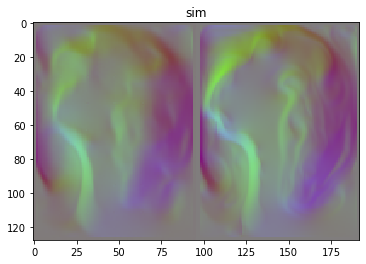

In [ ]:
outGif = '{}.gif'.format(versionName)
create_movie(Xrgb.detach().numpy(),outfile=outGif)

In [ ]:
simData = getSingleSim(sim=simVizIndex,dataDirec=testData)
simDataset = MantaFlowDataset(simData, reverseXY=reverseXY, numToKeep=numSamplesToKeep, AE=False)
simDataLoader = DataLoader(simDataset,batch_size=1)


100%|██████████| 200/200 [00:00<00:00, 526.66it/s]


In [ ]:
XX = []
Real_X = []
model.eval()
for i, sampleBatch in enumerate(simDataLoader,start=1):
    with torch.no_grad():
        X,p = sampleBatch
        X = X.to(device)
        p = p.to(device)
        Real_X.append(X)
        
        X_hat,_ = model(X)
        
        if createStreamFcn:
            X_hat = stream2uv(X_hat,device)
            
        XX.append(X_hat)
        
        #X = X.detach().cpu().squeeze()
        #X_hat = X_hat.detach().cpu().squeeze()
        #plotSampleWprediction(X, X_hat)

Real_X = torch.cat(Real_X,axis=0).to('cpu')
Real_X_img = convertSimToImage(Real_X)

Surr_X = torch.cat(XX,axis=0).to('cpu')
Surr_X_img = convertSimToImage(Surr_X)

### Metrics

In [ ]:
rmse(Real_X,Surr_X)

tensor(0.0389)

In [ ]:
rel_error = torch.norm(Real_X - Surr_X)/torch.norm(Real_X)
rel_error

tensor(0.2920)

### Make Movie

In [ ]:
Xrgb = torch.cat([Real_X_img, Surr_X_img], dim=3)
Xrgb.shape

torch.Size([200, 3, 128, 192])

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


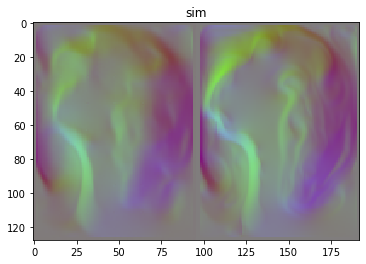

In [ ]:
outGif = '{}.gif'.format(versionName)
create_movie(Xrgb.detach().numpy(),outfile=outGif)

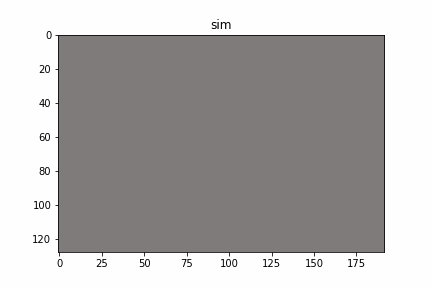

In [ ]:
from IPython.display import Image
Image(filename=outGif)

In [ ]:
for simVizIndex in range(10):
    simData = getSingleSim(sim=simVizIndex,dataDirec=testData)
    simDataset = MantaFlowDataset(simData, reverseXY=reverseXY, numToKeep=numSamplesToKeep, AE=False)
    simDataLoader = DataLoader(simDataset,batch_size=1)

    XX = []
    Real_X = []
    model.eval()
    for i, sampleBatch in enumerate(simDataLoader,start=1):
        with torch.no_grad():
            X,p = sampleBatch
            X = X.to(device)
            p = p.to(device)
            Real_X.append(X)

            X_hat,_ = model(X)

            if createStreamFcn:
                X_hat = stream2uv(X_hat,device)

            XX.append(X_hat)

            #X = X.detach().cpu().squeeze()
            #X_hat = X_hat.detach().cpu().squeeze()
            #plotSampleWprediction(X, X_hat)

    Real_X = torch.cat(Real_X,axis=0).to('cpu')
    Real_X_img = convertSimToImage(Real_X)

    Surr_X = torch.cat(XX,axis=0).to('cpu')
    Surr_X_img = convertSimToImage(Surr_X)

    ### Metrics

    print(rmse(Real_X,Surr_X))

    rel_error = torch.norm(Real_X - Surr_X)/torch.norm(Real_X)
    print(rel_error)

    ### Make Movie

    Xrgb = torch.cat([Real_X_img, Surr_X_img], dim=3)
    Xrgb.shape

    outGif = '{}_{}.gif'.format(versionName,simVizIndex)
    create_movie(Xrgb.detach().numpy(),outfile=outGif)
    Image(filename=outGif)




100%|██████████| 200/200 [00:00<00:00, 533.83it/s]
MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


tensor(0.0389)
tensor(0.2920)
